## Initating the Random Forest Model

In [354]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [355]:
import pandas as pd
ml_deepak = pd.read_csv("gold_df.csv")
df = ml_deepak.copy()

In [356]:
unique_venues = df['venue'].nunique()
print(f"Total number of unique venues IPL matches were played at: {unique_venues}")

Total number of unique venues IPL matches were played at: 41


In [357]:
df.shape
df.describe()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256796 entries, 0 to 256795
Data columns (total 34 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        256796 non-null  int64  
 1   inning            256796 non-null  int64  
 2   batting_team      256796 non-null  object 
 3   bowling_team      256796 non-null  object 
 4   over              256796 non-null  int64  
 5   ball              256796 non-null  int64  
 6   batter            256796 non-null  object 
 7   bowler            256796 non-null  object 
 8   non_striker       256796 non-null  object 
 9   batsman_runs      256796 non-null  int64  
 10  extra_runs        256796 non-null  int64  
 11  total_runs        256796 non-null  int64  
 12  extras_type       256796 non-null  object 
 13  is_wicket         256796 non-null  int64  
 14  player_dismissed  256796 non-null  object 
 15  dismissal_kind    256796 non-null  object 
 16  id                25

## Base model - Predicting the winner before match

In [358]:
# Data for model training
# Keeing only the necessary columns
columns_to_keep = ["winner", "team1", "team2", "city", "venue"]
df_bmp = df[columns_to_keep]
df_bmp = df_bmp.dropna()


In [359]:
#describing the before match prediction data
df_bmp.shape
df_bmp.describe()
df_bmp.count()
df_bmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256796 entries, 0 to 256795
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   winner  256796 non-null  object
 1   team1   256796 non-null  object
 2   team2   256796 non-null  object
 3   city    256796 non-null  object
 4   venue   256796 non-null  object
dtypes: object(5)
memory usage: 9.8+ MB


In [360]:
#Feature Selection and Encoding 
features = ["team1", "team2", "city", "venue"]
target = "winner"

# Drop missing and make a copy
df_model = df_bmp[features + [target]].dropna().copy()


In [361]:
#Encoding categorical variables
label_encoders = {}
for col in df_model.columns:
    if df_model[col].dtype == 'object':
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col])
        label_encoders[col] = le


   Train Size  Test Size  Accuracy
0         0.9        0.1     80.17
1         0.8        0.2     80.20
2         0.7        0.3     79.99
3         0.6        0.4     79.99


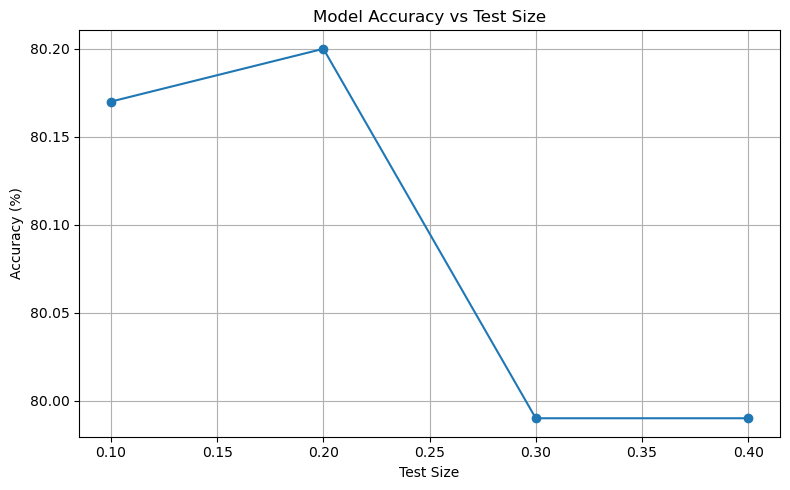

In [362]:
# Splitting the data into training and testing sets
# Split features and target
X = df_model[features]
y = df_model[target]

# Define test size range
test_sizes = [0.1, 0.2, 0.3, 0.4]
results = []

# Train and evaluate model on different test sizes
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        "Train Size": round(1 - test_size, 2),
        "Test Size": test_size,
        "Accuracy": round(acc * 100, 2)
    })

    # Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Plotting the results
# Plot the accuracy vs test size
plt.figure(figsize=(8, 5))
plt.plot(results_df["Test Size"], results_df["Accuracy"], marker='o')
plt.title("Model Accuracy vs Test Size")
plt.xlabel("Test Size")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


Best test size: 0.2 with Accuracy: 80.2%


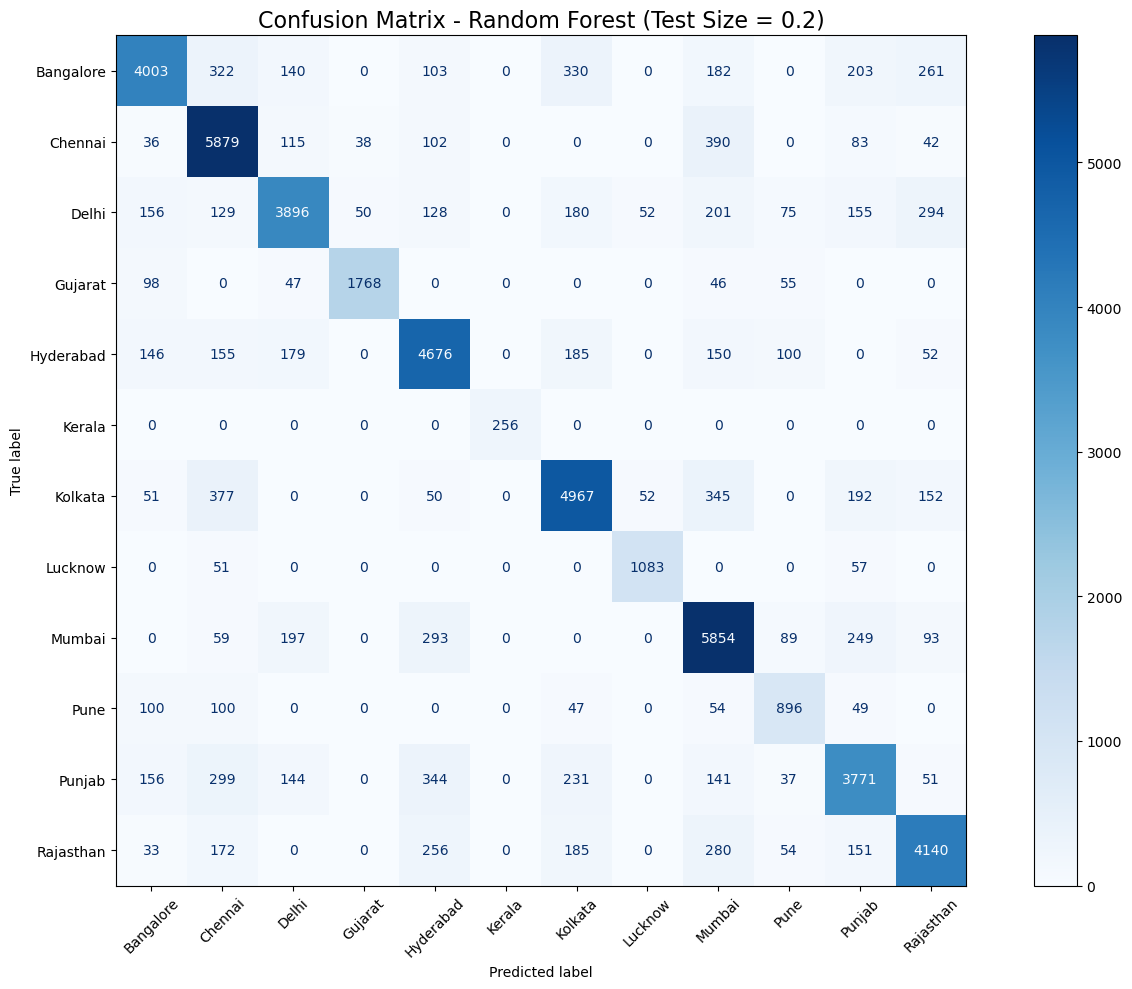

In [363]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Find best split based on Accuracy
best_split = max(results, key=lambda x: x['Accuracy'])
best_test_size = best_split["Test Size"]
print(f"\nBest test size: {best_test_size} with Accuracy: {best_split['Accuracy']}%")

# Step 2: Re-train model on best split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_test_size, random_state=42)
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Step 3: Plot the Confusion Matrix
#cm = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
target_names = label_encoders[target].classes_
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

fig, ax = plt.subplots(figsize=(14, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, values_format='.0f')
plt.title(f"Confusion Matrix - Random Forest (Test Size = {best_test_size})", fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.show()


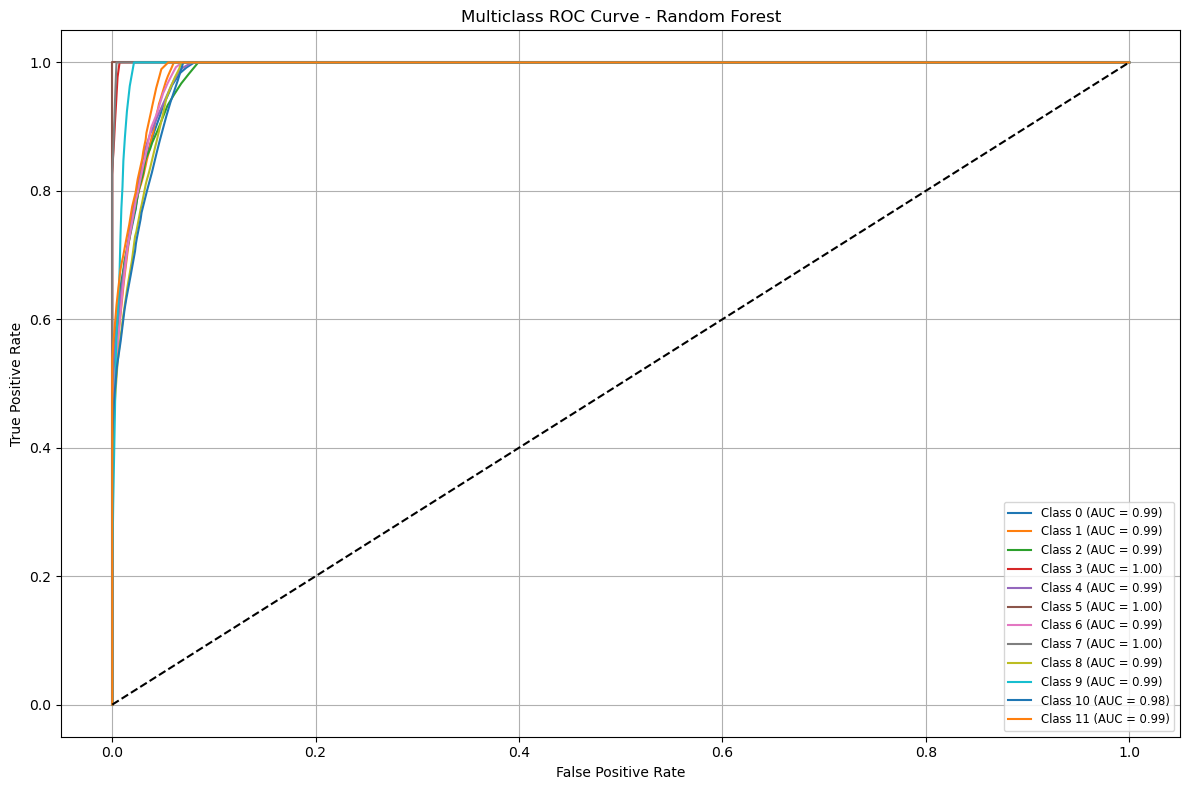

In [364]:
#ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Binarize the true labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = model.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12, 8))
for i in range(y_score.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Multiclass ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


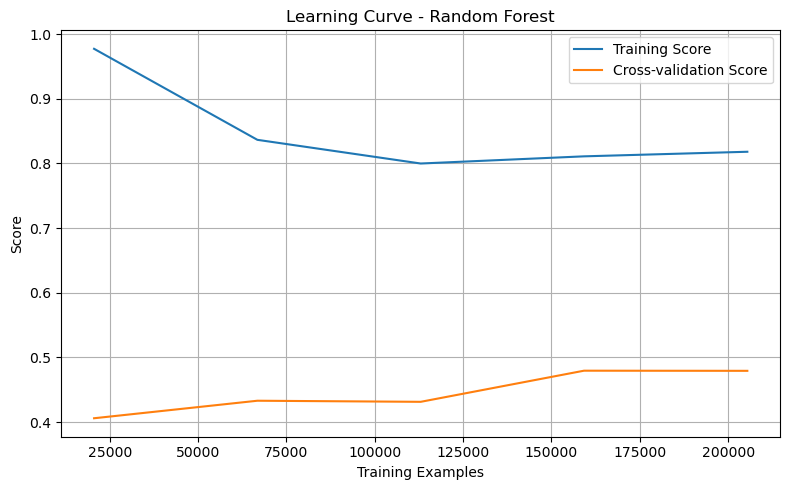

In [365]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label="Training Score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation Score")
plt.title("Learning Curve - Random Forest")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [366]:
#Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.72      0.78      5544
           1       0.78      0.88      0.83      6685
           2       0.83      0.73      0.78      5316
           3       0.95      0.88      0.91      2014
           4       0.79      0.83      0.81      5643
           5       1.00      1.00      1.00       256
           6       0.81      0.80      0.81      6186
           7       0.91      0.91      0.91      1191
           8       0.77      0.86      0.81      6834
           9       0.69      0.72      0.70      1246
          10       0.77      0.73      0.75      5174
          11       0.81      0.79      0.80      5271

    accuracy                           0.80     51360
   macro avg       0.83      0.82      0.82     51360
weighted avg       0.80      0.80      0.80     51360



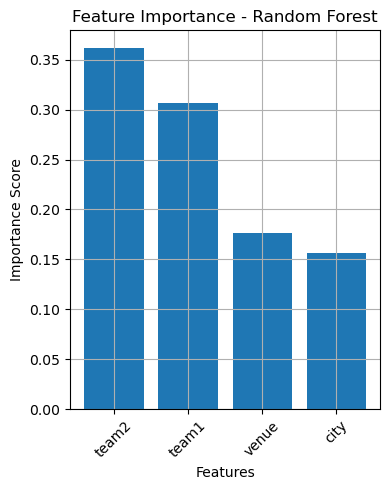

In [367]:
# Feature Importance Plot
import matplotlib.pyplot as plt
import pandas as pd

# Feature names (used during training)
feature_names = ["team1", "team2", "city", "venue"]

# Get feature importances from the trained model
importances = best_model.feature_importances_
indices = importances.argsort()[::-1]

# Plot
plt.figure(figsize=(4, 5))
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()


### Hyper-Parameter tuning 

In [368]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import time

# Sample a manageable subset (e.g., 50K for tuning)
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=50000, stratify=y, random_state=42)

# Use 70/30 split on the sample
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=42)

# Hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Randomized Search
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring='accuracy'
)

# Run the search
start = time.time()
random_search.fit(X_train, y_train)
end = time.time()

# Results
print(f"\n RandomizedSearchCV completed in {round((end - start) / 60, 2)} minutes")
print("Best Parameters:", random_search.best_params_)

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("\n Classification Report:")
print(classification_report(y_test, y_pred))
print(f" Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_es

In [369]:
#Hyperparameter Tuning with Different Test Sizes
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import time
import pandas as pd

# Sample a manageable subset (e.g., 50K)
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=50000, stratify=y, random_state=42)

# Test sizes to try
test_sizes = [0.1, 0.2, 0.3, 0.4]

# Hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Store results
results = []

# Loop over test sizes
for test_size in test_sizes:
    print(f"\n🔄 Running for test_size = {test_size}...")
    
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=test_size, random_state=42)
    
    rf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=30,
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42,
        scoring='accuracy'
    )

    start = time.time()
    random_search.fit(X_train, y_train)
    end = time.time()

    best_rf = random_search.best_estimator_
    y_pred = best_rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))

    # Record result
    results.append({
        'Test Size': test_size,
        'Train Size': round(1 - test_size, 2),
        'Accuracy (%)': round(acc * 100, 2),
        'Best Parameters': random_search.best_params_,
        'Tuning Time (mins)': round((end - start) / 60, 2)
    })

# Show all results in a table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy (%)", ascending=False).reset_index(drop=True)

print("\n✅ Summary of Tuning Across Test Sizes:")
display(results_df)



🔄 Running for test_size = 0.1...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.69      0.76       583
           1       0.80      0.86      0.83       639
           2       0.77      0.75      0.76       481
           3       0.95      0.88      0.92       191
           4       0.80      0.81      0.80       524
           5       1.00      1.00      1.00        23
           6       0.78      0.85      0.82       593
           7       0.91      0.95      0.93       113
           8       0.78      0.88      0.83       705
           9       0.60      0.79      0.68       104
          10       0.76      0.70      0.73       516
          11       0.85      0.75      0.79       528

    accuracy                           0.80      5000
   macro avg       0.82      0.83      0.82      5000
weighted avg       0.80      0.80      0.80      5000


🔄 Running 

,Test Size,Train Size,Accuracy (%),Best Parameters,Tuning Time (mins)
0,0.1,0.9,80.00,"{'n_estimators': 200, 'min_samples_split': 10,...",1.28
1,0.2,0.8,79.92,"{'n_estimators': 100, 'min_samples_split': 10,...",1.09
2,0.3,0.7,79.87,"{'n_estimators': 200, 'min_samples_split': 10,...",0.99
3,0.4,0.6,79.83,"{'n_estimators': 500, 'min_samples_split': 2, ...",0.92


## Model to predict the match winner after the toss

In [370]:
# Data for model training
# Keeing only the necessary columns
columns_to_keep = ["winner", "team1", "team2", "city", "venue", "toss_winner", "toss_decision"]
df_at = df[columns_to_keep]
df_at = df_at.dropna()


In [371]:
df_at.shape
df_at.describe()
df_at.count()
df_at.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256796 entries, 0 to 256795
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   winner         256796 non-null  object
 1   team1          256796 non-null  object
 2   team2          256796 non-null  object
 3   city           256796 non-null  object
 4   venue          256796 non-null  object
 5   toss_winner    256796 non-null  object
 6   toss_decision  256796 non-null  object
dtypes: object(7)
memory usage: 13.7+ MB


In [372]:
#Feature Selection and Encoding 
features = ["team1", "team2", "city", "venue", "toss_winner", "toss_decision"]
target = "winner"

# Drop missing and make a copy
df_model_two = df_at[features + [target]].dropna().copy()


In [373]:
#Encoding categorical variables
label_encoders = {}
for col in df_model_two.columns:
    if df_model_two[col].dtype == 'object':
        le = LabelEncoder()
        df_model_two[col] = le.fit_transform(df_model_two[col])
        label_encoders[col] = le


   Train Size  Test Size  Accuracy
0         0.9        0.1     87.85
1         0.8        0.2     87.86
2         0.7        0.3     87.72
3         0.6        0.4     87.73


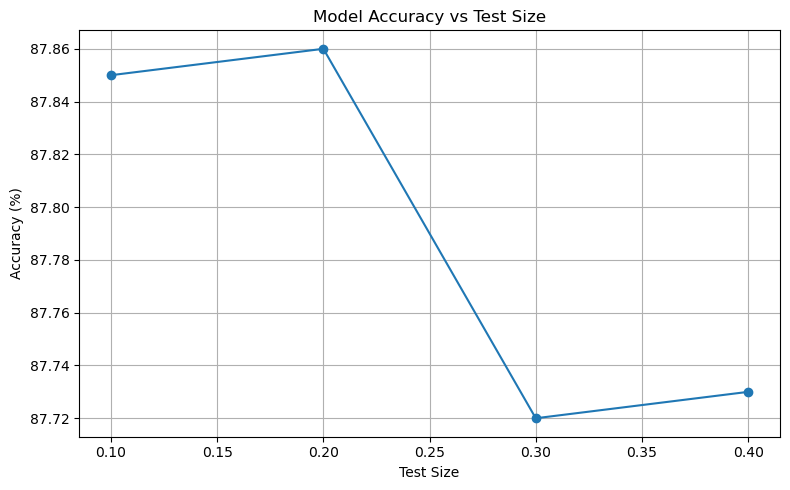

In [374]:
# Splitting the data into training and testing sets
# Split features and target
X = df_model_two[features]
y = df_model_two[target]

# Define test size range
test_sizes = [0.1, 0.2, 0.3, 0.4]
results = []

# Train and evaluate model on different test sizes
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        "Train Size": round(1 - test_size, 2),
        "Test Size": test_size,
        "Accuracy": round(acc * 100, 2)
    })

    # Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Plotting the results
# Plot the accuracy vs test size
plt.figure(figsize=(8, 5))
plt.plot(results_df["Test Size"], results_df["Accuracy"], marker='o')
plt.title("Model Accuracy vs Test Size")
plt.xlabel("Test Size")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Best test size: 0.2 with Accuracy: 87.86%


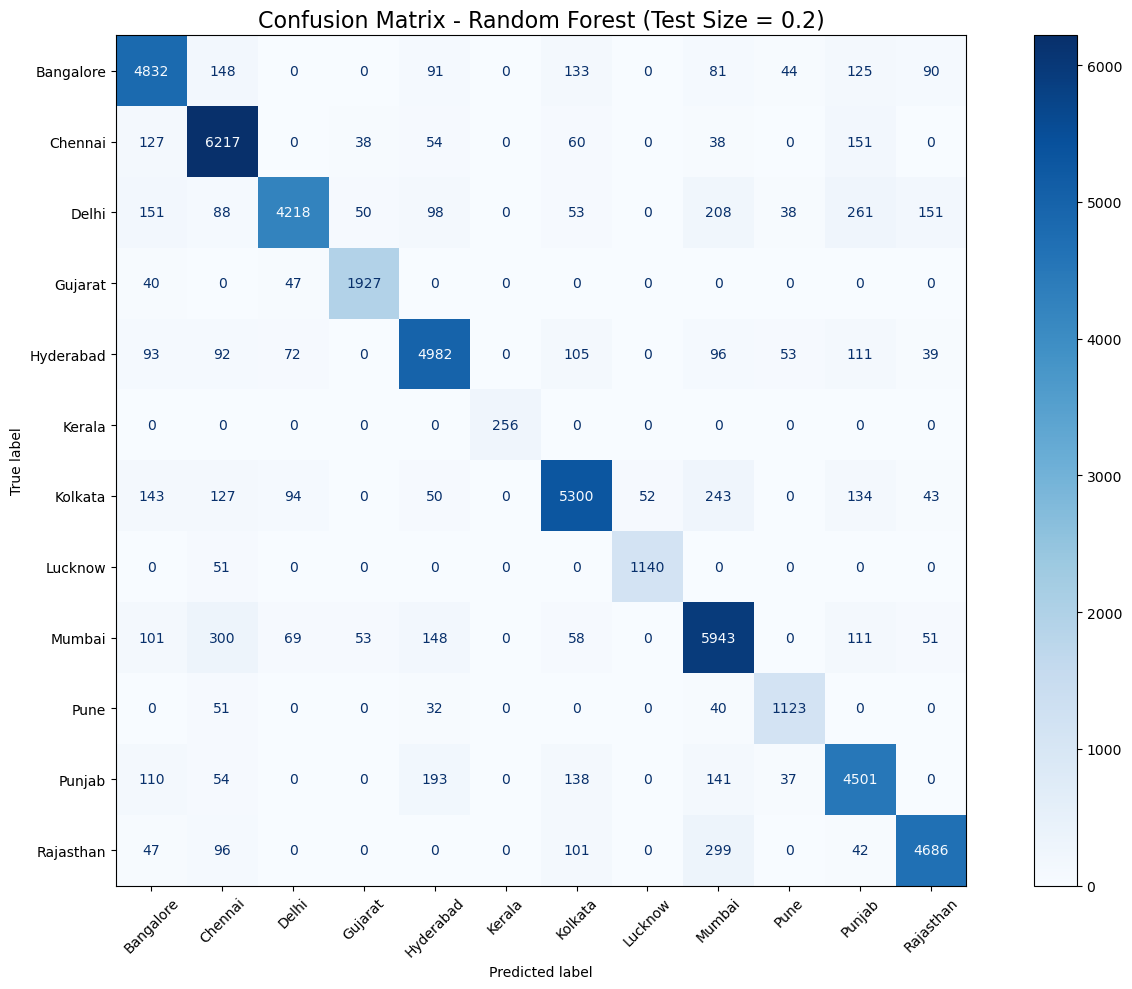

In [375]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Find best split based on Accuracy
best_split = max(results, key=lambda x: x['Accuracy'])
best_test_size = best_split["Test Size"]
print(f"\n✅ Best test size: {best_test_size} with Accuracy: {best_split['Accuracy']}%")

# Step 2: Re-train model on best split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_test_size, random_state=42)
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Step 3: Plot the Confusion Matrix
#cm = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
target_names = label_encoders[target].classes_
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

fig, ax = plt.subplots(figsize=(14, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, values_format='.0f')
plt.title(f"Confusion Matrix - Random Forest (Test Size = {best_test_size})", fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.show()


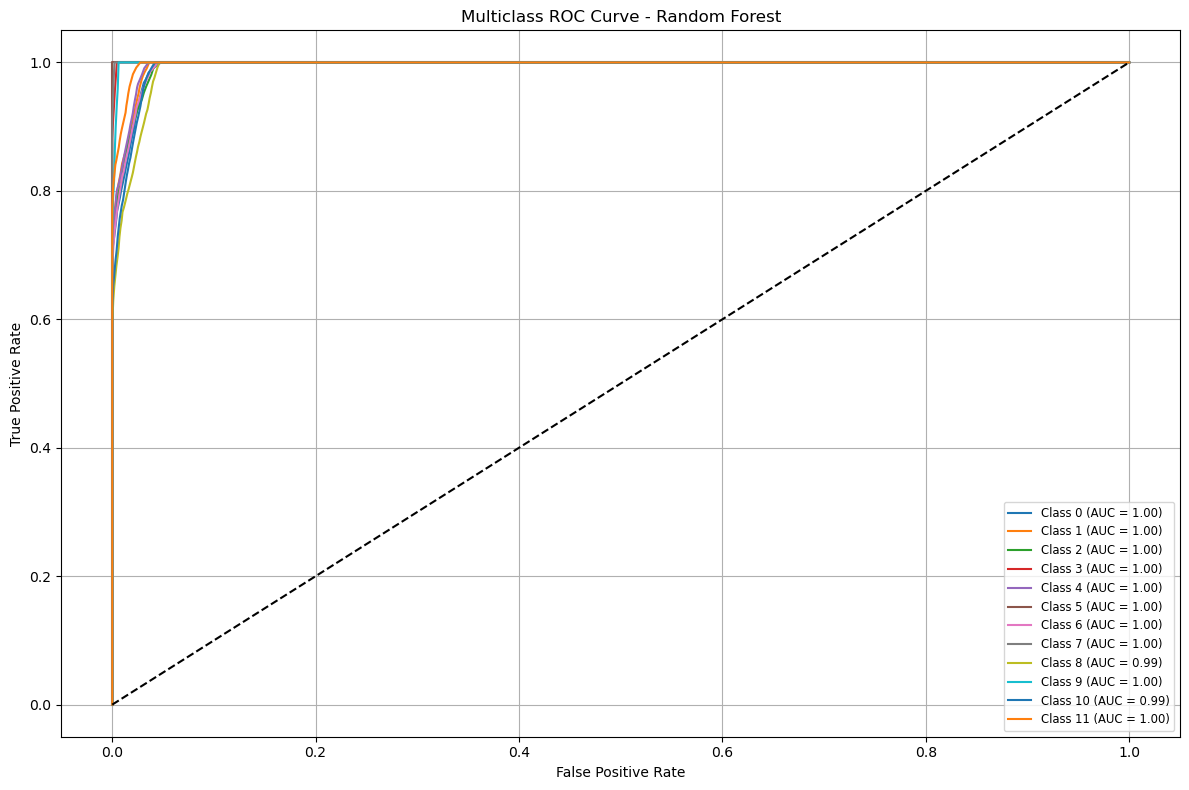

In [376]:
#ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Binarize the true labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = model.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12, 8))
for i in range(y_score.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Multiclass ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


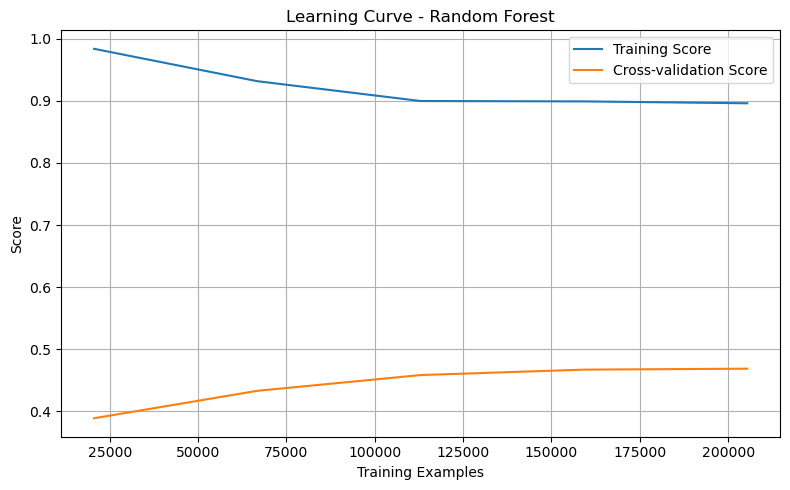

In [377]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 5), n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_scores_mean, label="Training Score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation Score")
plt.title("Learning Curve - Random Forest")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [378]:
#Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      5544
           1       0.86      0.93      0.89      6685
           2       0.94      0.79      0.86      5316
           3       0.93      0.96      0.94      2014
           4       0.88      0.88      0.88      5643
           5       1.00      1.00      1.00       256
           6       0.89      0.86      0.87      6186
           7       0.96      0.96      0.96      1191
           8       0.84      0.87      0.85      6834
           9       0.87      0.90      0.88      1246
          10       0.83      0.87      0.85      5174
          11       0.93      0.89      0.91      5271

    accuracy                           0.88     51360
   macro avg       0.90      0.90      0.90     51360
weighted avg       0.88      0.88      0.88     51360



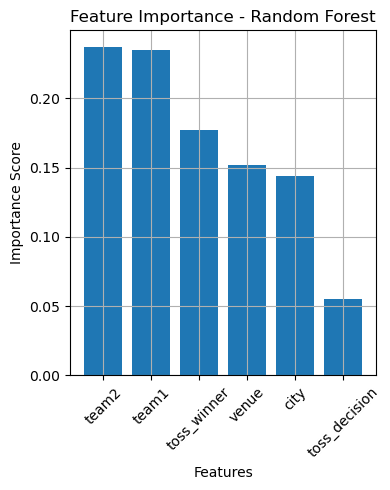

In [379]:
# Feature Importance Plot
import matplotlib.pyplot as plt
import pandas as pd

# Feature names (used during training)
feature_names = ["team1", "team2", "city", "venue", "toss_winner", "toss_decision"]

# Get feature importances from the trained model
importances = best_model.feature_importances_
indices = importances.argsort()[::-1]

# Plot
plt.figure(figsize=(4, 5))
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [380]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import time

# Sample a manageable subset (e.g., 50K for tuning)
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=50000, stratify=y, random_state=42)

# Use 70/30 split on the sample
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42)

# Hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Randomized Search
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring='accuracy'
)

# Run the search
start = time.time()
random_search.fit(X_train, y_train)
end = time.time()

# Results
print(f"\n⏱️ RandomizedSearchCV completed in {round((end - start) / 60, 2)} minutes")
print("✅ Best Parameters:", random_search.best_params_)

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))
print(f"🎯 Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   1.3s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_es

In [381]:
#Hyperparameter Tuning with Different Test Sizes
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
import time
import pandas as pd

# Sample a manageable subset (e.g., 50K)
X_sample, _, y_sample, _ = train_test_split(X, y, train_size=50000, stratify=y, random_state=42)

# Test sizes to try
test_sizes = [0.1, 0.2, 0.3, 0.4]

# Hyperparameter grid
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Store results
results = []

# Loop over test sizes
for test_size in test_sizes:
    print(f"\n🔄 Running for test_size = {test_size}...")
    
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=test_size, random_state=42)
    
    rf = RandomForestClassifier(random_state=42)
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=30,
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42,
        scoring='accuracy'
    )

    start = time.time()
    random_search.fit(X_train, y_train)
    end = time.time()

    best_rf = random_search.best_estimator_
    y_pred = best_rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))

    # Record result
    results.append({
        'Test Size': test_size,
        'Train Size': round(1 - test_size, 2),
        'Accuracy (%)': round(acc * 100, 2),
        'Best Parameters': random_search.best_params_,
        'Tuning Time (mins)': round((end - start) / 60, 2)
    })

# Show all results in a table
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="Accuracy (%)", ascending=False).reset_index(drop=True)

print("\n✅ Summary of Tuning Across Test Sizes:")
display(results_df)



🔄 Running for test_size = 0.1...
Fitting 5 folds for each of 30 candidates, totalling 150 fits

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       583
           1       0.88      0.92      0.90       639
           2       0.91      0.83      0.87       481
           3       0.94      0.92      0.93       191
           4       0.86      0.89      0.88       524
           5       1.00      1.00      1.00        23
           6       0.86      0.89      0.88       593
           7       0.96      0.95      0.95       113
           8       0.85      0.91      0.88       705
           9       0.90      0.90      0.90       104
          10       0.85      0.83      0.84       516
          11       0.93      0.89      0.91       528

    accuracy                           0.88      5000
   macro avg       0.90      0.90      0.90      5000
weighted avg       0.88      0.88      0.88      5000


🔄 Running 

,Test Size,Train Size,Accuracy (%),Best Parameters,Tuning Time (mins)
0,0.1,0.9,88.04,"{'n_estimators': 200, 'min_samples_split': 2, ...",1.36
1,0.2,0.8,87.93,"{'n_estimators': 200, 'min_samples_split': 10,...",1.16
2,0.4,0.6,87.91,"{'n_estimators': 200, 'min_samples_split': 10,...",0.91
3,0.3,0.7,87.85,"{'n_estimators': 300, 'min_samples_split': 5, ...",1.06


## Model to Pridect the match winner after 1st inning

In [382]:
df_fi = df[df["inning"] == 1]

columns_to_keep = ['winner','team1', 'team2', 'venue', 'city', 'season', 'toss_winner', 'toss_decision', 'target_runs', 'target_overs', 'inning']
df_fi = df_fi[columns_to_keep]

df_fi = df_fi.dropna()

In [383]:
df_fi.shape
df_fi.describe()
df_fi.info()


<class 'pandas.core.frame.DataFrame'>
Index: 132820 entries, 0 to 256728
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   winner         132820 non-null  object 
 1   team1          132820 non-null  object 
 2   team2          132820 non-null  object 
 3   venue          132820 non-null  object 
 4   city           132820 non-null  object 
 5   season         132820 non-null  int64  
 6   toss_winner    132820 non-null  object 
 7   toss_decision  132820 non-null  object 
 8   target_runs    132820 non-null  float64
 9   target_overs   132820 non-null  float64
 10  inning         132820 non-null  int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 12.2+ MB


In [384]:
#Feature Selection and Encoding 
features = ['team1', 'team2','toss_winner', 'toss_decision', 'target_runs', 'target_overs','city', 'venue']
target = 'winner'

# Drop missing and make a copy
df_model_three = df_fi[features + [target]].dropna().copy()


In [385]:
#Encoding categorical variables
label_encoders = {}
for col in df_model_three.columns:
    if df_model_three[col].dtype == 'object':
        le = LabelEncoder()
        df_model_three[col] = le.fit_transform(df_model_three[col])
        label_encoders[col] = le


   Train Size  Test Size  Accuracy
0         0.9        0.1     99.91
1         0.8        0.2     99.92
2         0.7        0.3     99.92
3         0.6        0.4     99.92


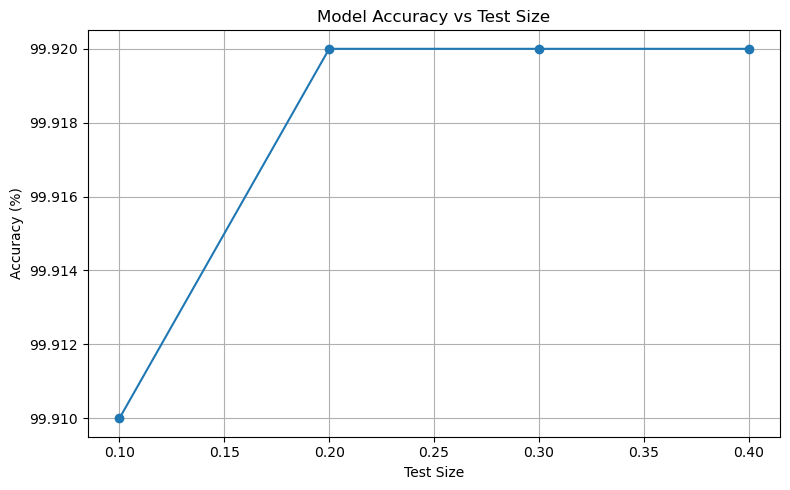

In [386]:
# Splitting the data into training and testing sets
# Split features and target
X = df_model_three[features]
y = df_model_three[target]

# Define test size range
test_sizes = [0.1, 0.2, 0.3, 0.4]
results = []

# Train and evaluate model on different test sizes
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        "Train Size": round(1 - test_size, 2),
        "Test Size": test_size,
        "Accuracy": round(acc * 100, 2)
    })

    # Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Plotting the results
# Plot the accuracy vs test size
plt.figure(figsize=(8, 5))
plt.plot(results_df["Test Size"], results_df["Accuracy"], marker='o')
plt.title("Model Accuracy vs Test Size")
plt.xlabel("Test Size")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Best test size: 0.2 with Accuracy: 99.92%


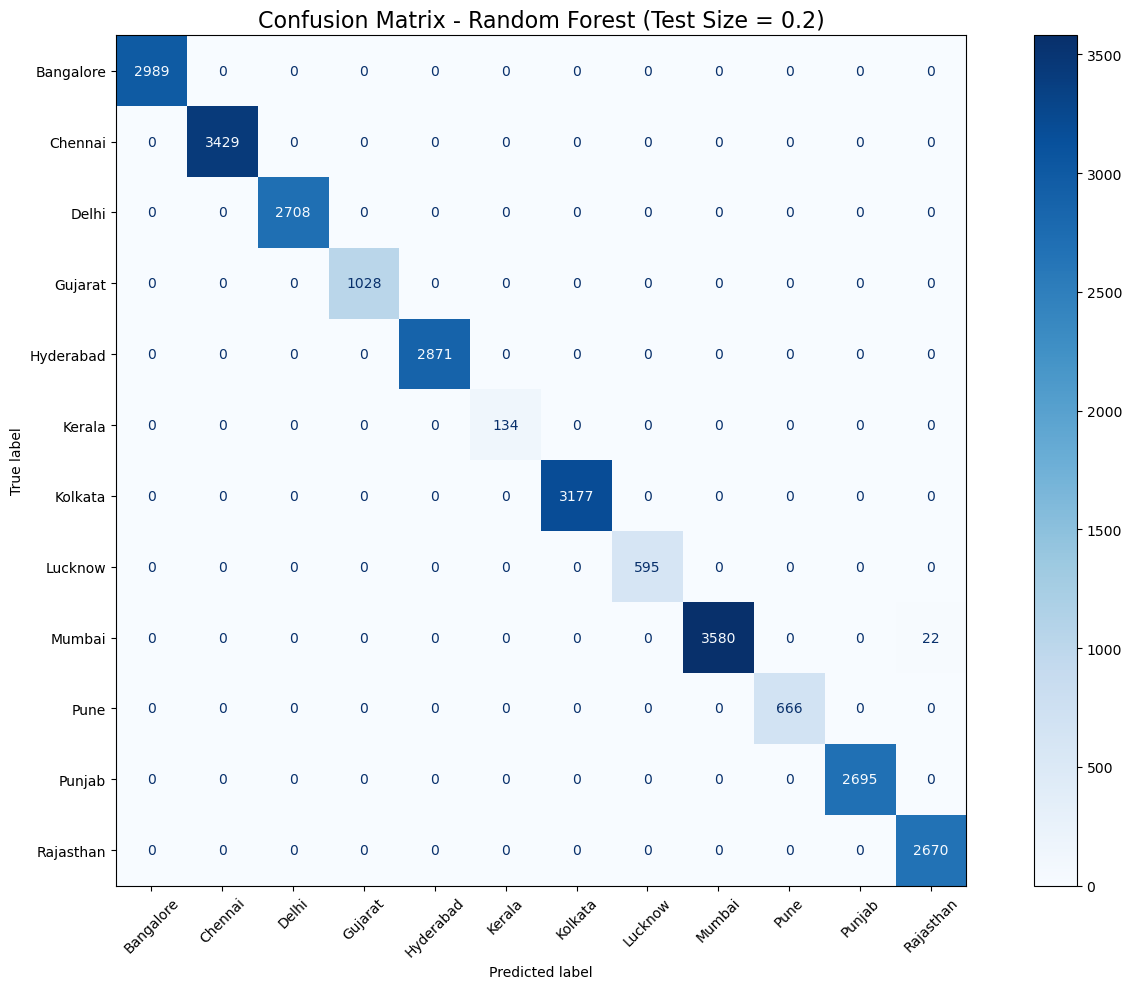

In [387]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Find best split based on Accuracy
best_split = max(results, key=lambda x: x['Accuracy'])
best_test_size = best_split["Test Size"]
print(f"\n✅ Best test size: {best_test_size} with Accuracy: {best_split['Accuracy']}%")

# Step 2: Re-train model on best split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_test_size, random_state=42)
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Step 3: Plot the Confusion Matrix
target_names = label_encoders[target].classes_
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

fig, ax = plt.subplots(figsize=(14, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, values_format='.0f')
plt.title(f"Confusion Matrix - Random Forest (Test Size = {best_test_size})", fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.show()


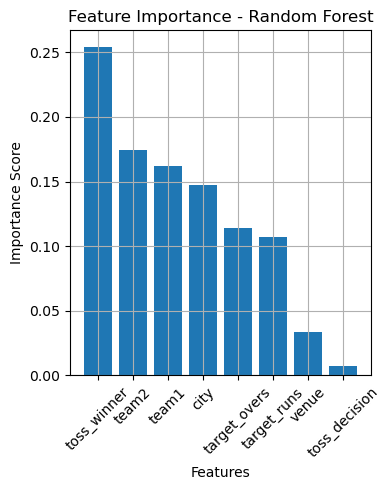

In [388]:
# Feature Importance Plot
import matplotlib.pyplot as plt
import pandas as pd

# Feature names (used during training)
feature_names = ["team1", "team2", "city", "venue", "toss_winner", "toss_decision", "target_runs", "target_overs"]

# Get feature importances from the trained model
importances = best_model.feature_importances_
indices = importances.argsort()[::-1]

# Plot
plt.figure(figsize=(4, 5))
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()


## Preparing Aggrigated Datset 

In [389]:
import pandas as pd

ml_deepak = pd.read_csv("gold_df.csv")
df = ml_deepak.copy()

# Step 1: Reuse the provided aggregation logic
def aggregate_by_innings(df):
    inning1_df = df[df['inning'] == 1].groupby('id').agg(
        inning1_runs=('total_runs', 'sum'),
        inning1_wickets=('is_wicket', 'sum'),
        inning1_balls=('ball', 'count')
    ).reset_index()

    inning2_df = df[df['inning'] == 2].groupby('id').agg(
        inning2_runs=('total_runs', 'sum'),
        inning2_wickets=('is_wicket', 'sum'),
        inning2_balls=('ball', 'count')
    ).reset_index()

    aggregated_df = pd.merge(inning1_df, inning2_df, on='id', how='left').fillna(0)

    match_details = df[[
        'id', 'season', 'city', 'venue', 'toss_winner', 'toss_decision',
        'winner', 'team1', 'team2', 'batting_team', 'bowling_team'
    ]].drop_duplicates(subset=['id'])

    aggregated_df = pd.merge(aggregated_df, match_details, on='id', how='left')
    return aggregated_df

# Apply aggregation
aggregated_df = aggregate_by_innings(df)

# Step 2: Create modeling datasets
pre_match_df = aggregated_df[['id', 'season', 'city', 'venue', 'team1', 'team2', 'winner']]
post_toss_df = aggregated_df[['id', 'season', 'city', 'venue', 'team1', 'team2', 'toss_winner', 'toss_decision', 'winner','batting_team', 'bowling_team']]
mid_match_df = aggregated_df[['id', 'season', 'city', 'venue', 'team1', 'team2', 'toss_winner', 'toss_decision', 'inning1_runs', 'inning1_wickets', 'inning1_balls', 'winner','batting_team', 'bowling_team']]

# Preview
print("Pre-Match DF:")
print(pre_match_df.head(), "\n")

print("Post-Toss DF:")
print(post_toss_df.head(), "\n")

print("Mid-Match DF:")
print(mid_match_df.head(), "\n")

#Extract to CSV
#pre_match_df.to_csv("pre_match_df.csv", index=False)
#post_toss_df.to_csv("post_toss_df.csv", index=False)
#mid_match_df.to_csv("mid_match_df.csv", index=False)


Pre-Match DF:
       id  season        city                               venue      team1  \
0  335982    2008   Bangalore               M Chinnaswamy Stadium  Bangalore   
1  335983    2008  Chandigarh  Punjab Cricket Association Stadium     Punjab   
2  335984    2008       Delhi                    Feroz Shah Kotla      Delhi   
3  335985    2008      Mumbai                    Wankhede Stadium     Mumbai   
4  335986    2008     Kolkata                        Eden Gardens    Kolkata   

       team2     winner  
0    Kolkata    Kolkata  
1    Chennai    Chennai  
2  Rajasthan      Delhi  
3  Bangalore  Bangalore  
4  Hyderabad    Kolkata   

Post-Toss DF:
       id  season        city                               venue      team1  \
0  335982    2008   Bangalore               M Chinnaswamy Stadium  Bangalore   
1  335983    2008  Chandigarh  Punjab Cricket Association Stadium     Punjab   
2  335984    2008       Delhi                    Feroz Shah Kotla      Delhi   
3  335985    

### Predicting Match winner before mtach

In [390]:
pre_match_df.shape
pre_match_df.describe()
pre_match_df.count()
pre_match_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1076 non-null   int64 
 1   season  1076 non-null   int64 
 2   city    1076 non-null   object
 3   venue   1076 non-null   object
 4   team1   1076 non-null   object
 5   team2   1076 non-null   object
 6   winner  1076 non-null   object
dtypes: int64(2), object(5)
memory usage: 59.0+ KB


In [391]:
#Feature Selection and Encoding 
features = ["team1", "team2", "city", "venue"]
target = "winner"

# Drop missing and make a copy
df_model = pre_match_df[features + [target]].dropna().copy()


In [392]:
#Encoding categorical variables
label_encoders = {}
for col in df_model.columns:
    if df_model[col].dtype == 'object':
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col])
        label_encoders[col] = le


   Train Size  Test Size  Accuracy
0         0.9        0.1     43.52
1         0.8        0.2     46.30
2         0.7        0.3     46.75
3         0.6        0.4     43.16


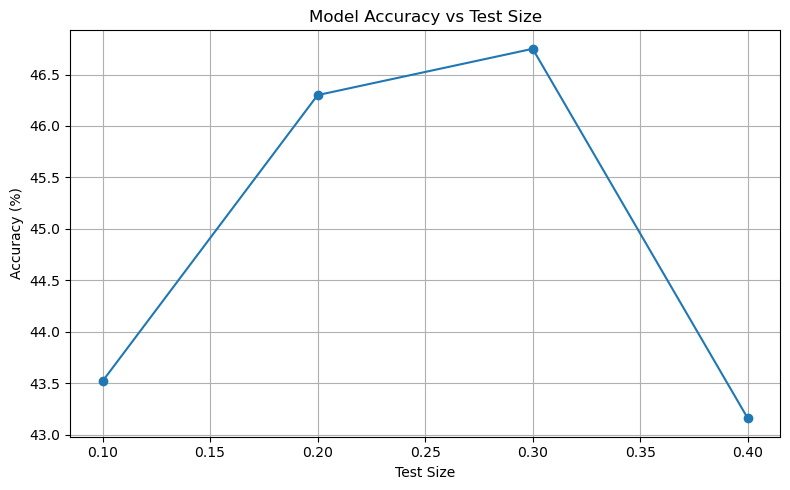

In [393]:
# Splitting the data into training and testing sets
# Split features and target
X = df_model[features]
y = df_model[target]

# Define test size range
test_sizes = [0.1, 0.2, 0.3, 0.4]
results = []

# Train and evaluate model on different test sizes
for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append({
        "Train Size": round(1 - test_size, 2),
        "Test Size": test_size,
        "Accuracy": round(acc * 100, 2)
    })

    # Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

# Plotting the results
# Plot the accuracy vs test size
plt.figure(figsize=(8, 5))
plt.plot(results_df["Test Size"], results_df["Accuracy"], marker='o')
plt.title("Model Accuracy vs Test Size")
plt.xlabel("Test Size")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


Best test size: 0.3 with Accuracy: 46.75%


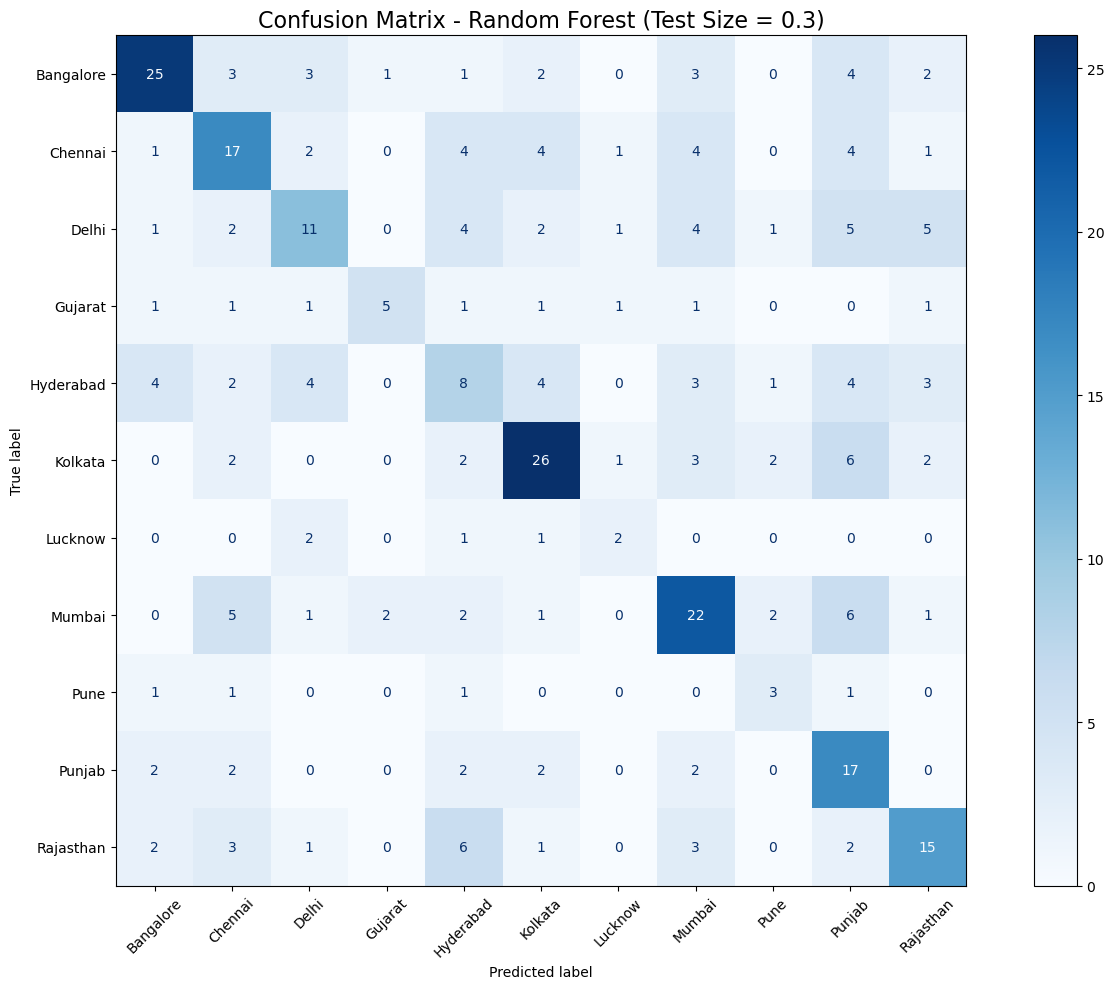

In [394]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Find best split based on Accuracy
best_split = max(results, key=lambda x: x['Accuracy'])
best_test_size = best_split["Test Size"]
print(f"\nBest test size: {best_test_size} with Accuracy: {best_split['Accuracy']}%")

# Step 2: Re-train model on best split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=best_test_size, random_state=42)
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Step 3: Plot the Confusion Matrix
#cm = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
# Ensure the target names match the unique classes in y_test
unique_classes = np.unique(y_test)
target_names = label_encoders[target].inverse_transform(unique_classes)
cm = confusion_matrix(y_test, y_pred, labels=unique_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

fig, ax = plt.subplots(figsize=(14, 10))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, values_format='.0f')
plt.title(f"Confusion Matrix - Random Forest (Test Size = {best_test_size})", fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.show()


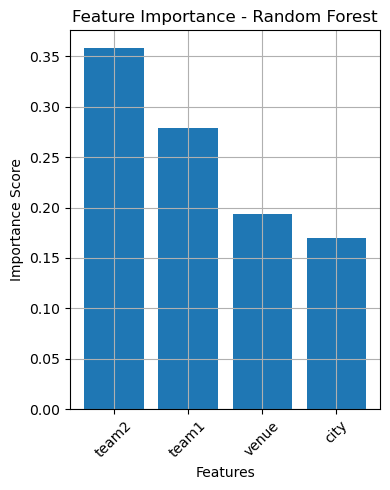

In [395]:
# Feature Importance Plot
import matplotlib.pyplot as plt
import pandas as pd

# Feature names (used during training)
feature_names = ["team1", "team2", "city", "venue"]

# Get feature importances from the trained model
importances = best_model.feature_importances_
indices = importances.argsort()[::-1]

# Plot
plt.figure(figsize=(4, 5))
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=45)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.grid(True)
plt.tight_layout()
plt.show()


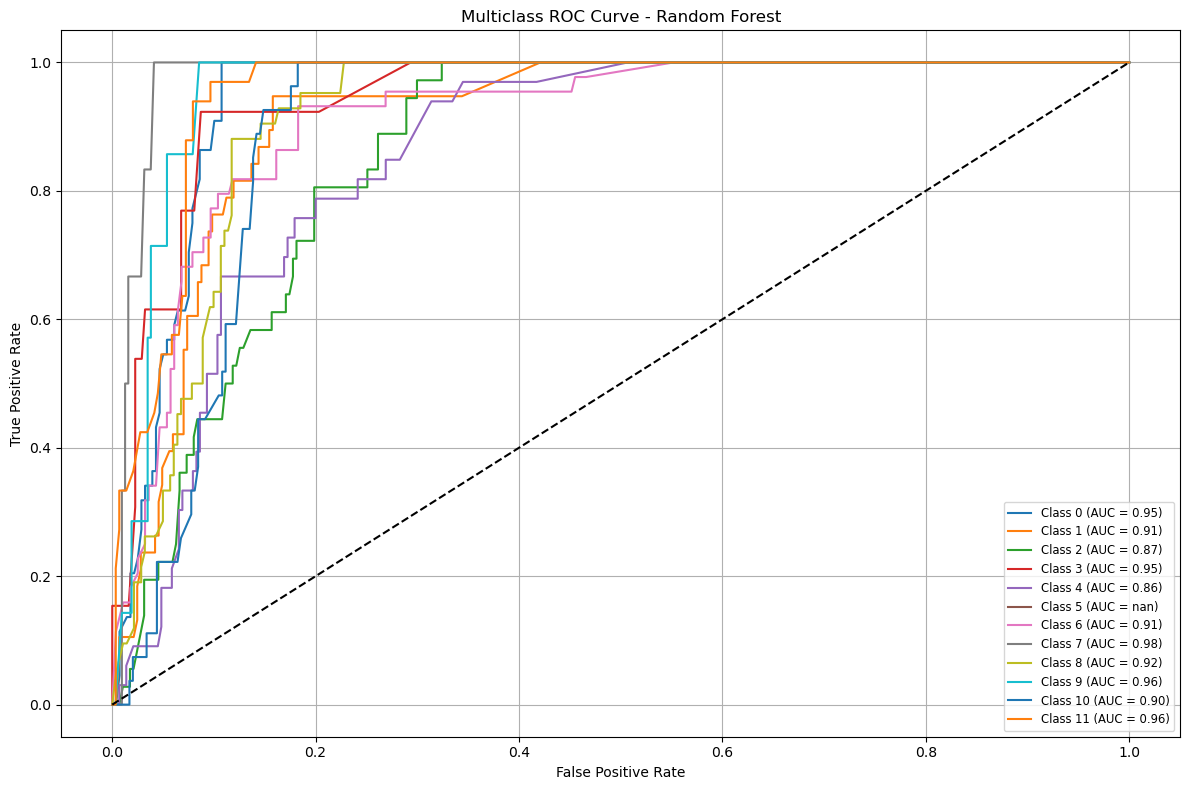

In [396]:
#ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Binarize the true labels for multiclass ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_score = model.predict_proba(X_test)

fpr = {}
tpr = {}
roc_auc = {}

plt.figure(figsize=(12, 8))
for i in range(y_score.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("Multiclass ROC Curve - Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


## Binary Classification Approach

In [397]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

ml_deepak = pd.read_csv("gold_df.csv")
df = ml_deepak.copy()

In [398]:
def aggregate_by_innings(df):
    """
    Aggregates match-level data from ball-by-ball gold_df.
    Creates 1 row per match with inning1 and inning2 summaries.
    """
    # First innings
    inning1_df = df[df['inning'] == 1].groupby('id').agg(
        inning1_runs=('total_runs', 'sum'),
        inning1_wickets=('is_wicket', 'sum'),
        inning1_balls=('ball', 'count')
    ).reset_index()

    # Second innings
    inning2_df = df[df['inning'] == 2].groupby('id').agg(
        inning2_runs=('total_runs', 'sum'),
        inning2_wickets=('is_wicket', 'sum'),
        inning2_balls=('ball', 'count')
    ).reset_index()

    # Merge the two innings
    aggregated_df = pd.merge(inning1_df, inning2_df, on='id', how='left').fillna(0)

    # Match-level metadata (only one row per match)
    match_details = df[[
        'id', 'season', 'city', 'venue', 'toss_winner', 'toss_decision',
        'winner', 'result', 'result_margin', 'player_of_match',
        'team1', 'team2', 'batting_team', 'bowling_team'
    ]].drop_duplicates(subset=['id'])

    # Merge metadata with aggregated innings data
    aggregated_df = pd.merge(aggregated_df, match_details, on='id', how='left')

    return aggregated_df

# Step 3: Run aggregation function
aggregated_df = aggregate_by_innings(df)

# Step 4: (Optional) Preview the data
print(aggregated_df.head())
print(aggregated_df.shape)

# Step 5: Export to CSV
aggregated_df.to_csv("aggregated_match_data_by_innings.csv", index=False)


       id  inning1_runs  inning1_wickets  inning1_balls  inning2_runs  \
0  335982           222                3            124            82   
1  335983           240                5            124           207   
2  335984           129                8            122           132   
3  335985           165                7            123           166   
4  335986           110               10            118           112   

   inning2_wickets  inning2_balls  season        city  \
0               10            101    2008   Bangalore   
1                4            124    2008  Chandigarh   
2                1             97    2008       Delhi   
3                5            123    2008      Mumbai   
4                5            122    2008     Kolkata   

                                venue toss_winner toss_decision     winner  \
0               M Chinnaswamy Stadium   Bangalore         field    Kolkata   
1  Punjab Cricket Association Stadium     Chennai           ba

In [399]:
# Load your cleaned match-level dataset
df = pd.read_csv("aggregated_match_data_by_innings.csv")  # replace with gold_df if needed

# Drop rows with missing winner or teams
df = df.dropna(subset=['team1', 'team2', 'winner'])

# Create binary target: 1 if team1 won, else 0
df['target_binary'] = (df['winner'] == df['team1']).astype(int)

### Encoding 

In [400]:
# Select features relevant for prediction
features = ['team1', 'team2', 'venue', 'city', 'toss_winner', 'toss_decision','inning1_runs', 'inning1_wickets', 'inning1_balls','season']
target = 'target_binary'

# Drop rows with missing values in feature columns
df_model = df[features + [target]].dropna().copy()

# Encode categorical variables
label_encoders = {}
for col in features:
    if df_model[col].dtype == 'object':
        le = LabelEncoder()
        df_model[col] = le.fit_transform(df_model[col])
        label_encoders[col] = le


In [401]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split data
X = df_model[features]
y = df_model[target]

# Define test sizes to try
test_sizes = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]
split_results = []

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    split_results.append({
        "Train Size": round(1 - test_size, 2),
        "Test Size": test_size,
        "Accuracy": round(acc * 100, 2)
    })

# Display results
results_df = pd.DataFrame(split_results)
print("\n📊 Accuracy across Train/Test Splits:")
print(results_df.sort_values(by="Accuracy", ascending=False))



📊 Accuracy across Train/Test Splits:
   Train Size  Test Size  Accuracy
0        0.90       0.10     57.41
2        0.80       0.20     57.41
1        0.85       0.15     56.79
4        0.70       0.30     56.35
5        0.65       0.35     55.97
6        0.60       0.40     54.29
3        0.75       0.25     53.16


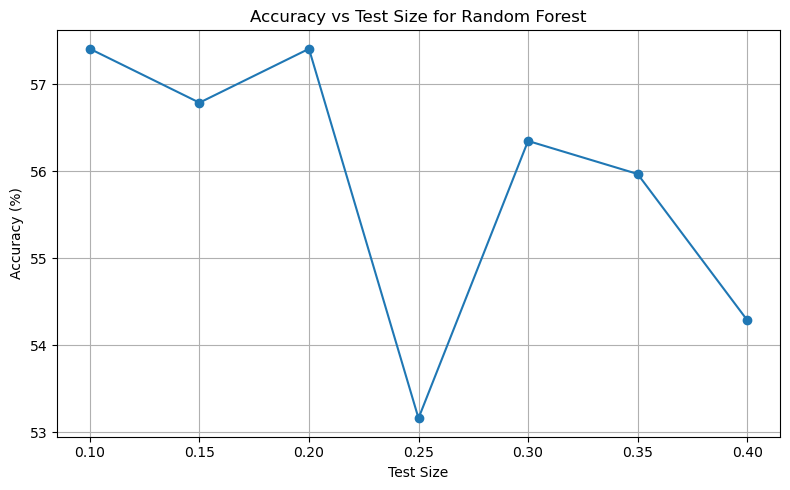

In [402]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(results_df["Test Size"], results_df["Accuracy"], marker='o')
plt.title("Accuracy vs Test Size for Random Forest")
plt.xlabel("Test Size")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [403]:
# Accuracy and Report
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 54.29%

Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.51      0.52       211
           1       0.55      0.57      0.56       220

    accuracy                           0.54       431
   macro avg       0.54      0.54      0.54       431
weighted avg       0.54      0.54      0.54       431



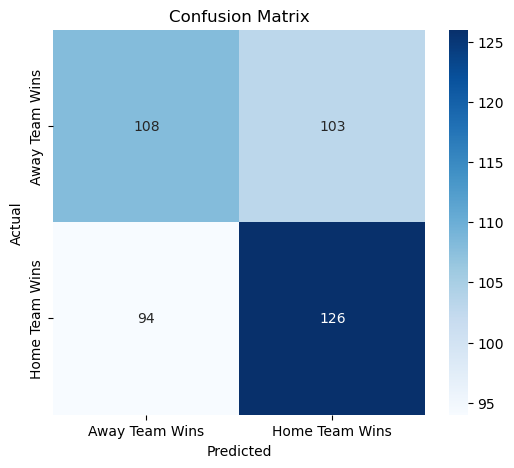

In [404]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["Away Team Wins", "Home Team Wins"], yticklabels=["Away Team Wins", "Home Team Wins"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


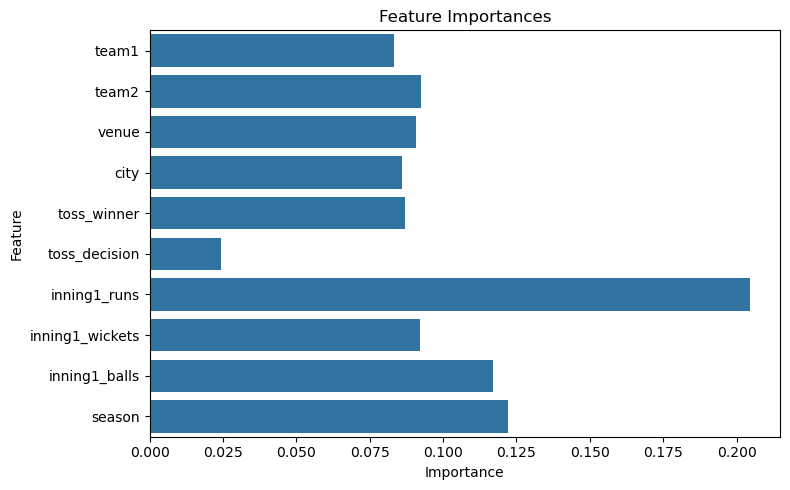

In [405]:
importances = model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


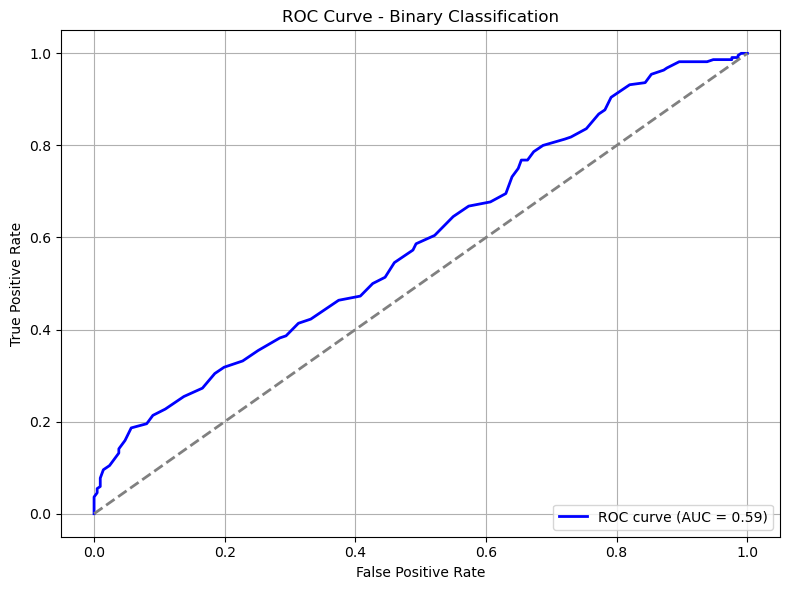

In [406]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for class 1 (positive class)
y_score = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.title('ROC Curve - Binary Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()


#### Hyper Paramenter Tuning for Binary classification 

In [407]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")


In [408]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}


In [409]:
best_accuracy = 0.0
final_model = None
final_X_test = None
final_y_test = None
split_results = []

test_sizes = [0.1, 0.15, 0.2, 0.25, 0.3]

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    # Tune model
    base_model = RandomForestClassifier(random_state=42)
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=10,
        cv=3,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    split_results.append({
        "Train Size": round(1 - test_size, 2),
        "Test Size": test_size,
        "Accuracy": round(acc * 100, 2),
        "Best Params": search.best_params_
    })

    print(f"\n✅ Split {1 - test_size:.2f}/{test_size:.2f} - Accuracy: {acc*100:.2f}%")
    print(f"Best Parameters: {search.best_params_}")

    # Save final model and data for plotting if it's the best
    if acc == max([r["Accuracy"] for r in split_results]):
        final_model = best_model
        final_X_test = X_test
        final_y_test = y_test



✅ Split 0.90/0.10 - Accuracy: 63.89%
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}

✅ Split 0.85/0.15 - Accuracy: 61.73%
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}

✅ Split 0.80/0.20 - Accuracy: 56.02%
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True}

✅ Split 0.75/0.25 - Accuracy: 55.76%
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

✅ Split 0.70/0.30 - Accuracy: 56.35%
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True}



📊 Accuracy across Train/Test Splits (with Tuning):
   Train Size  Test Size  Accuracy  \
0        0.90       0.10     63.89   
1        0.85       0.15     61.73   
4        0.70       0.30     56.35   
2        0.80       0.20     56.02   
3        0.75       0.25     55.76   

                                         Best Params  
0  {'n_estimators': 200, 'min_samples_split': 10,...  
1  {'n_estimators': 300, 'min_samples_split': 5, ...  
4  {'n_estimators': 200, 'min_samples_split': 10,...  
2  {'n_estimators': 200, 'min_samples_split': 10,...  
3  {'n_estimators': 200, 'min_samples_split': 2, ...  


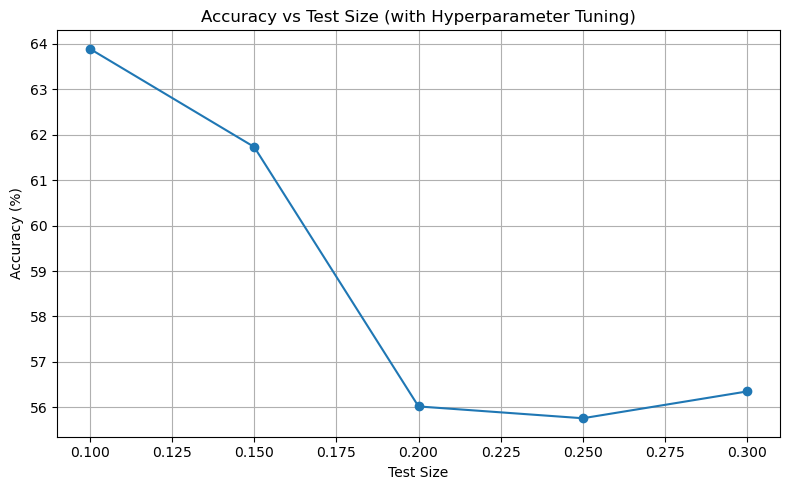

In [410]:
results_df = pd.DataFrame(split_results)
print("\n📊 Accuracy across Train/Test Splits (with Tuning):")
print(results_df.sort_values(by="Accuracy", ascending=False))

plt.figure(figsize=(8, 5))
plt.plot(results_df["Test Size"], results_df["Accuracy"], marker='o')
plt.title("Accuracy vs Test Size (with Hyperparameter Tuning)")
plt.xlabel("Test Size")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [411]:
best_accuracy = 0.0
final_model = None
final_X_test = None
final_y_test = None

test_sizes = [0.1, 0.15, 0.2, 0.25, 0.3]

for test_size in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )

    base_model = RandomForestClassifier(random_state=42)
    search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=10,
        cv=3,
        scoring='accuracy',
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    y_pred = best_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    split_results.append({
        "Train Size": round(1 - test_size, 2),
        "Test Size": test_size,
        "Accuracy": round(acc * 100, 2),
        "Best Params": search.best_params_
    })

    print(f"\n✅ Split {1 - test_size:.2f}/{test_size:.2f} - Accuracy: {acc*100:.2f}%")
    print(f"Best Parameters: {search.best_params_}")

    if acc > best_accuracy:
        best_accuracy = acc
        final_model = best_model
        final_X_test = X_test
        final_y_test = y_test



✅ Split 0.90/0.10 - Accuracy: 63.89%
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': False}

✅ Split 0.85/0.15 - Accuracy: 61.73%
Best Parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 10, 'bootstrap': True}

✅ Split 0.80/0.20 - Accuracy: 56.02%
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True}

✅ Split 0.75/0.25 - Accuracy: 55.76%
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

✅ Split 0.70/0.30 - Accuracy: 56.35%
Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True}


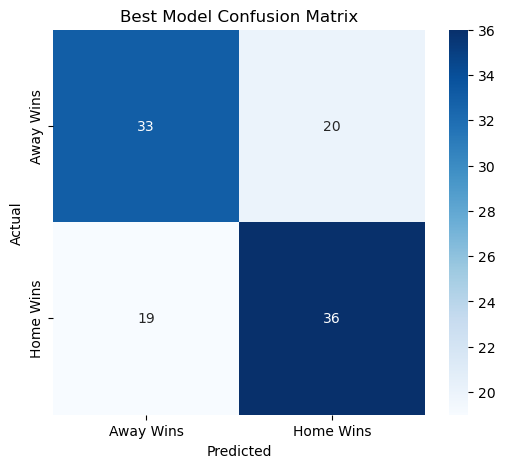

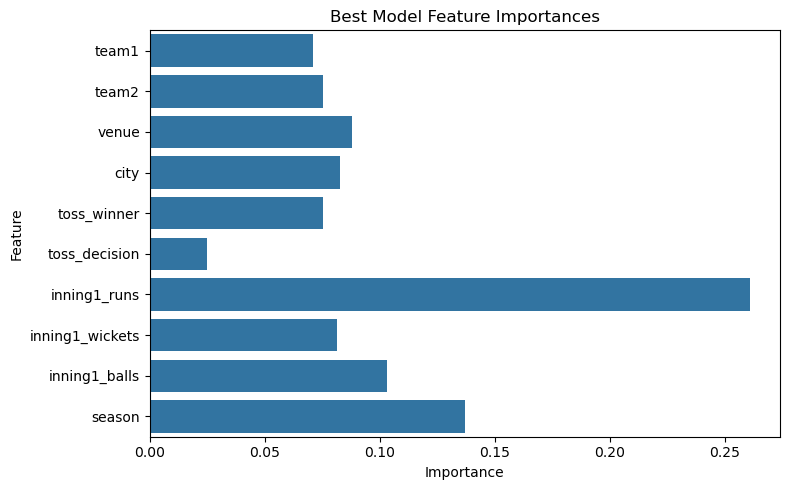

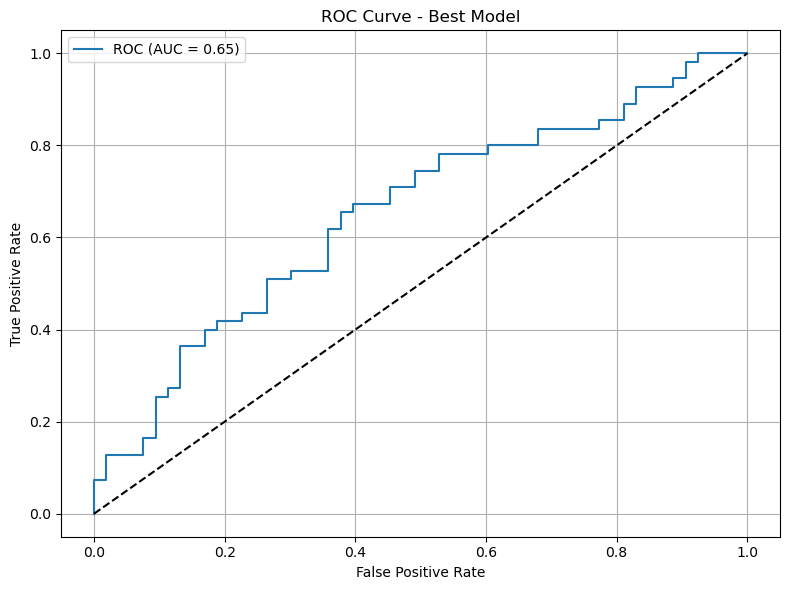

In [412]:
# Confusion Matrix
cm = confusion_matrix(final_y_test, final_model.predict(final_X_test))
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=["Away Wins", "Home Wins"], yticklabels=["Away Wins", "Home Wins"])
plt.title("Best Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance
importances = final_model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title('Best Model Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# ROC Curve
y_score = final_model.predict_proba(final_X_test)[:, 1]
fpr, tpr, _ = roc_curve(final_y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve - Best Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
